In [40]:
import random
import math
from HLL import HyperLogLog
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [50]:
NUM_ESTIMATORS = 6
MAX_MEMORY = 32 			# w = 32-bit
ERROR_TOLERANCE = 0.05
P_LIMIT = 25
NUM_TRIALS = 100			# for find_best_config_new

In [51]:


# order = 1 gives expectation, order = 2 gives squared variance
def moment_CC(m, inv_p, order):
	ret = [0]*m
	for j in range(m):
		val = inv_p/(m-j)
		if order == 2:
			val = val*val - val
		if j == 0:
			ret[j] = val
		else:
			ret[j] = ret[j-1] + val
	return ret

def relative_error(T, T_q):
	# print(abs(T - T_q)/T_q)
	return abs(T - T_q)/T_q

def CC_experiment(m, inv_p, T):
	MAX_TRY = 3*T				# 3 is arbitrary

	list_T = [MAX_TRY]*m
	collected = [0]*m
	num_collected = 0
	for it in range(1,MAX_TRY+1):				
		val = random.uniform(0,1)
		coupon = math.floor(val*inv_p)
		if coupon<m and collected[coupon] == 0:
			collected[coupon] = 1
			list_T[num_collected] = it
			num_collected += 1
			if num_collected == m:
				break
	return list_T


def CC_exp_rel_err(m, inv_p, T):
	list_error = [0]*m
	for trial in range(NUM_TRIALS):
		curr_list_T = CC_experiment(m, inv_p, T)
		# print(curr_list_T)
		for i in range(m):
			list_error[i] = list_error[i] + relative_error(curr_list_T[i], T)
	for i in range(m):
		list_error[i] = list_error[i]/NUM_TRIALS
	return list_error

def compute_error(m_q, inv_p_q, T_q, b):
	list_error = [0]*m_q
	list_exp = moment_CC(m_q, inv_p_q, 1)
	if b==0:
		list_error = CC_exp_rel_err(m_q, inv_p_q, T_q)
		bestind = 0
		for i in range(m_q):
			if relative_error(list_exp[i], T_q) > ERROR_TOLERANCE:		# relative error of the expectation here
				list_error[i] = math.inf
			if i!=0:
				if list_error[i] < list_error[bestind]:
					list_error[bestind] = math.inf
					bestind = i
				else:
					list_error[i] = math.inf	

	elif b==1:
		list_sqvar = moment_CC(m_q, inv_p_q, 2)
		for i in range(m_q):
			list_error[i] = (list_exp[i]-T_q)*(list_exp[i]-T_q)  + list_sqvar[i]

	return list_error

# This is forn iterating over powers of 2 for p
# b=0: minimizes the |T-T_q|/T_q for all possible things within 5% expectation range 
# actually run experiment and minimize average error
# b=1: minimizes the E[(T-T_q)^2] = Var[T]+(E[T]-T_q)^2
# ppow = 0 considers only p as powers of 2
def find_best_config(T_q, gamma_q, b, ppow):
	best_config = []
	smallest_error = float('inf')
	if ppow == 0:
		for i in range(P_LIMIT):
			inv_p_q = 2**i
			upperbound_m = int(min(MAX_MEMORY, gamma_q*inv_p_q))
			if upperbound_m < 1:
				continue
			for m_q in range(1,upperbound_m+1):
				list_curr_error = compute_error(m_q, inv_p_q, T_q, b) 	# value for each n_q in {1,...,m_q} 
				for n_q in range(1,m_q+1):
					curr_error = list_curr_error[n_q-1]
					if curr_error < smallest_error:
						best_config = [1, i, m_q, n_q]		# pnum = 1 in this case
						smallest_error = curr_error
	else:
		for m_q in range(1, MAX_MEMORY+1):
			list_p = moment_CC(m_q, 1/T_q, 1)
			for n_q in range(1, m_q+1):
				p_q = list_p[n_q-1]
				p_q_denom = 2**(P_LIMIT)
				p_q_num = math.floor(p_q * p_q_denom)
				p_q = p_q_num/p_q_denom
				p_q = min(p_q, gamma_q/m_q)
				list_curr_error = compute_error(m_q, 1/p_q, T_q, b)
				curr_error = list_curr_error[n_q-1]
				if curr_error < smallest_error:
					best_config = [p_q_num, P_LIMIT, m_q, n_q]		# pnum = 1 in this case
					smallest_error = curr_error


	prob = best_config[0]/(2**best_config[1])
	inv_prob = 1/prob
	m_q = best_config[2]
	n_q = best_config[3]
	ind = n_q-1

	# Bias
	list_exp = moment_CC(m_q, inv_prob, 1)
	bias  = relative_error(list_exp[ind], T_q)
	# Relative error
	list_rel_error = CC_exp_rel_err(m_q, inv_prob, T_q)
	rel_error = list_rel_error[ind]
	# Square relative error
	list_sqvar = moment_CC(m_q, inv_prob, 2)
	sq_rel_error = (list_exp[ind]-T_q)*(list_exp[ind]-T_q)  + list_sqvar[ind]
	l2_rel_error = (math.sqrt(sq_rel_error))/T_q
	return (best_config, bias, rel_error, l2_rel_error)


In [52]:
def relative_error(T, T_q):
	return abs(T - T_q)/T_q

def sq_error(T, T_q):
    return (T - T_q)**2

def HLL_reaching_threshold(p, T_q):
    n_q = p * T_q
    hll = HyperLogLog(NUM_ESTIMATORS)
    MAX_TRY = 3*T_q
    for i in range(1, MAX_TRY + 1):
        val = random.uniform(0,1)
        if val <= p:
            hll.add(str(i) + str(random.random()))
            if hll.cardinality() >= n_q:
                return i
    return MAX_TRY

def HLL_error_experiment(p, T_q):
    sum_rel_error = 0
    sum_sq_error = 0
    for trial in range(NUM_TRIALS):
        num_packets = HLL_reaching_threshold(p, T_q)
        # print(num_packets)
        sum_rel_error += relative_error(num_packets, T_q)
        sum_sq_error += sq_error(num_packets, T_q)
    rel_error_average = sum_rel_error/NUM_TRIALS
    sq_error_average = sum_sq_error/NUM_TRIALS
    l2_rel_error_average = math.sqrt(sq_error_average)/T_q
    return rel_error_average, l2_rel_error_average

In [53]:
list_gammas = [2**(-i) for i in range(10)]
T_q = 1000

# plot for HLL
list_rel_error_HLL = []
list_l2_rel_error_HLL = []
for gamma in list_gammas:
    p = gamma
    curr_rel_error_HLL, curr_l2_rel_error_HLL = HLL_error_experiment(p, T_q)
    list_rel_error_HLL.append(curr_rel_error_HLL)
    list_l2_rel_error_HLL.append(curr_l2_rel_error_HLL)

# plot for BC b=0 (minimize relative error) ppow=0 (only power of 2)
list_rel_error_BC00 = []
list_l2_rel_error_BC00 = []
b = 0
ppow = 0
for gamma in list_gammas:
    curr_best_config, bias, rel_error, l2_rel_error = find_best_config(T_q, gamma, b, ppow)
    list_rel_error_BC00.append(rel_error)
    list_l2_rel_error_BC00.append(l2_rel_error)

# plot for BC b=0 (minimize relative error) ppow=1 
list_rel_error_BC01 = []
list_l2_rel_error_BC01 = []
b = 0
ppow = 1
for gamma in list_gammas:
    curr_best_config, bias, rel_error, l2_rel_error = find_best_config(T_q, gamma, b, ppow)
    list_rel_error_BC01.append(rel_error)
    list_l2_rel_error_BC01.append(l2_rel_error)

# plot for BC b=1 (minimize variance) ppow=0 (only power of 2)
list_rel_error_BC10 = []
list_l2_rel_error_BC10 = []
b = 1
ppow = 0
for gamma in list_gammas:
    curr_best_config, bias, rel_error, l2_rel_error = find_best_config(T_q, gamma, b, ppow)
    list_rel_error_BC10.append(rel_error)
    list_l2_rel_error_BC10.append(l2_rel_error)

# plot for BC b=1 (minimize variance) ppow=1
list_rel_error_BC11 = []
list_l2_rel_error_BC11 = []
b = 1
ppow = 1
for gamma in list_gammas:
    curr_best_config, bias, rel_error, l2_rel_error = find_best_config(T_q, gamma, b, ppow)
    list_rel_error_BC11.append(rel_error)
    list_l2_rel_error_BC11.append(l2_rel_error)

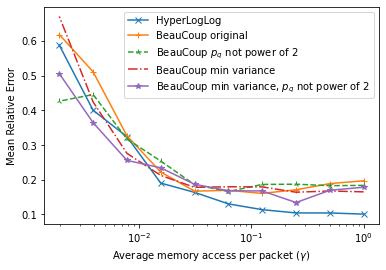

In [69]:
# plot relative error
plt.plot(list_gammas, list_rel_error_HLL, "x-", label="HyperLogLog")
plt.plot(list_gammas, list_rel_error_BC00, "+-", label="BeauCoup original")
plt.plot(list_gammas, list_rel_error_BC01, "2--", label="BeauCoup $p_q$ not power of 2")
plt.plot(list_gammas, list_rel_error_BC10, "-.", label="BeauCoup min variance")
plt.plot(list_gammas, list_rel_error_BC11, "*-", label="BeauCoup min variance, $p_q$ not power of 2")

plt.ylabel("Mean Relative Error")
plt.xscale('log', basex=10)
plt.xlabel('Average memory access per packet ($\gamma$)')
plt.legend()
plt.show()

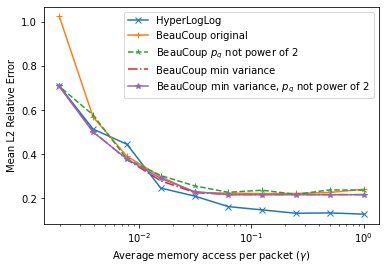

In [70]:
# plot relative error
plt.plot(list_gammas, list_l2_rel_error_HLL, "x-", label="HyperLogLog")
plt.plot(list_gammas, list_l2_rel_error_BC00, "+-", label="BeauCoup original")
plt.plot(list_gammas, list_l2_rel_error_BC01, "2--", label="BeauCoup $p_q$ not power of 2")
plt.plot(list_gammas, list_l2_rel_error_BC10, "-.", label="BeauCoup min variance")
plt.plot(list_gammas, list_l2_rel_error_BC11, "*-", label="BeauCoup min variance, $p_q$ not power of 2")

plt.ylabel("Mean L2 Relative Error")
plt.xscale('log', basex=10)
plt.xlabel('Average memory access per packet ($\gamma$)')
plt.legend()
plt.show()